In [146]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import dmba 
import math
from scipy.stats import yeojohnson
from sklearn.model_selection import cross_val_score, StratifiedKFold 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from joblib import dump

In [22]:
df=pd.read_csv('telecom_churn.csv')

df.head(15)


,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
5,0,118,0,0,0.00,0,223.4,98,57.0,11.03,6.3
6,0,121,1,1,2.03,3,218.2,88,87.3,17.43,7.5
7,0,147,0,0,0.00,0,157.0,79,36.0,5.16,7.1
8,0,117,1,0,0.19,1,184.5,97,63.9,17.58,8.7
9,0,141,0,1,3.02,0,258.6,84,93.2,11.10,11.2


In [4]:
df.describe().round(3)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000,3333.000,3333.000,3333.000,3333.000,3333.000,3333.000,3333.000,3333.000,3333.000,3333.000
mean,0.145,101.065,0.903,0.277,0.816,1.563,179.775,100.436,56.305,10.051,10.237
std,0.352,39.822,0.296,0.447,1.273,1.315,54.467,20.069,16.426,2.536,2.792
min,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,14.000,0.000,0.000
25%,0.000,74.000,1.000,0.000,0.000,1.000,143.700,87.000,45.000,8.330,8.500
50%,0.000,101.000,1.000,0.000,0.000,1.000,179.400,101.000,53.500,10.070,10.300
75%,0.000,127.000,1.000,1.000,1.780,2.000,216.400,114.000,66.200,11.770,12.100
max,1.000,243.000,1.000,1.000,5.400,9.000,350.800,165.000,111.300,18.190,20.000


In [5]:
df.shape

(3333, 11)

In [6]:
df.isna().sum()

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
(df==0).sum()

Churn              2850
AccountWeeks          0
ContractRenewal     323
DataPlan           2411
DataUsage          1813
CustServCalls       697
DayMins               2
DayCalls              2
MonthlyCharge         0
OverageFee            1
RoamMins             18
dtype: int64

In [9]:
df.nunique()

Churn                 2
AccountWeeks        212
ContractRenewal       2
DataPlan              2
DataUsage           174
CustServCalls        10
DayMins            1667
DayCalls            119
MonthlyCharge       627
OverageFee         1024
RoamMins            162
dtype: int64

In [10]:
count=df['Churn'].value_counts()
print(count)

Churn
0    2850
1     483
Name: count, dtype: int64


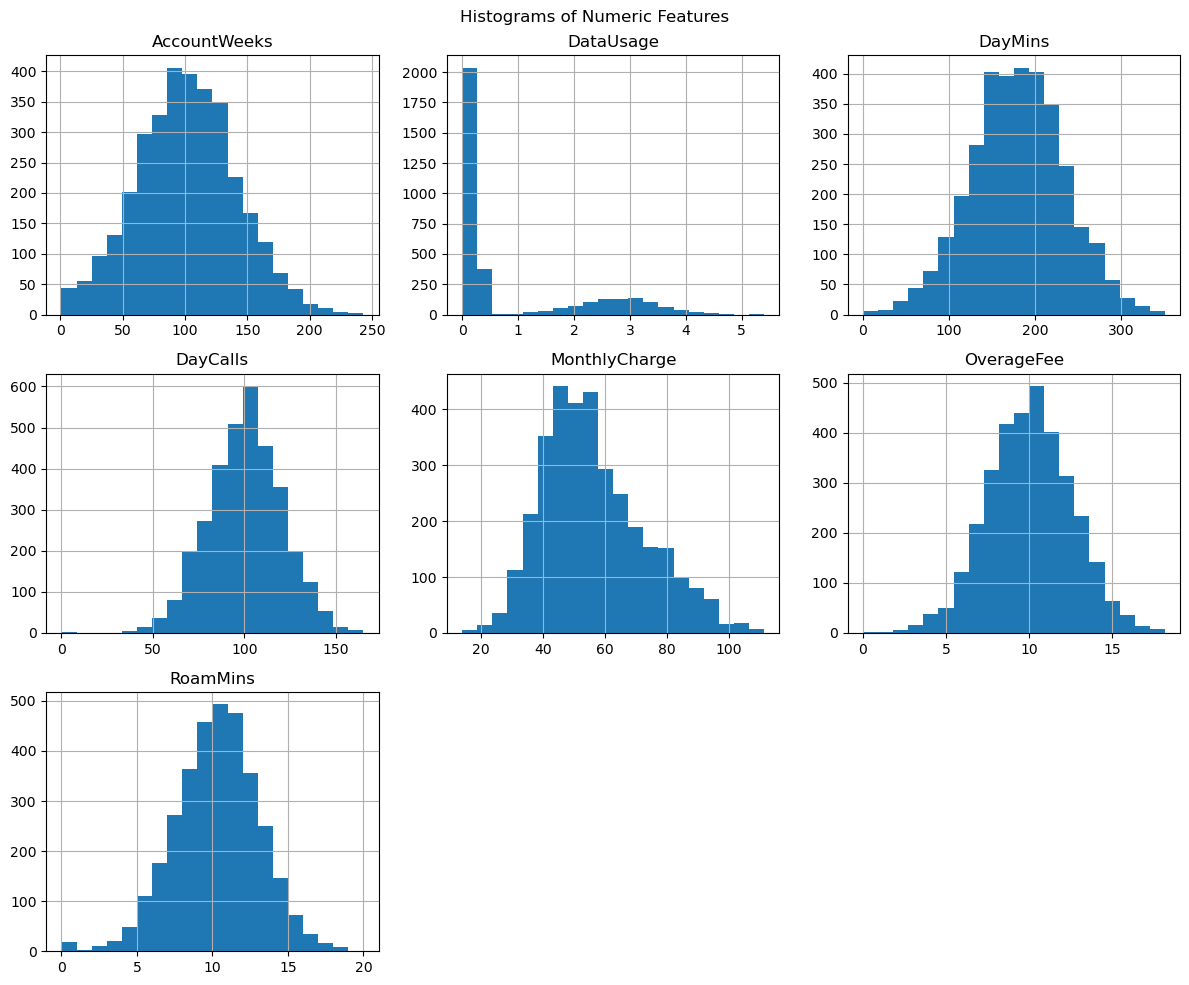

In [30]:
df[['AccountWeeks','DataUsage','DayMins','DayCalls','MonthlyCharge','OverageFee','RoamMins']].hist(bins=20,figsize=(12,10))
plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()

λ = -1.8457937216986422


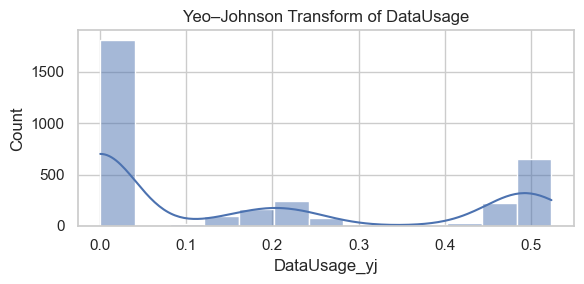

In [58]:
# apply Yeo-Johnson
df['DataUsage_yj'], fitted_lambda = yeojohnson(df['DataUsage'])
print("λ =", fitted_lambda)

# visualize
plt.figure(figsize=(6,3))
sns.histplot(df['DataUsage_yj'], kde=True)
plt.title("Yeo–Johnson Transform of DataUsage")
plt.tight_layout()
plt.show()

In [75]:
#deleting extra columns because i used multiple models to check 
df.drop(columns=['DataUsage_log','DataUsage_boxcox','DataUsage_yj'], axis=1,inplace=True)

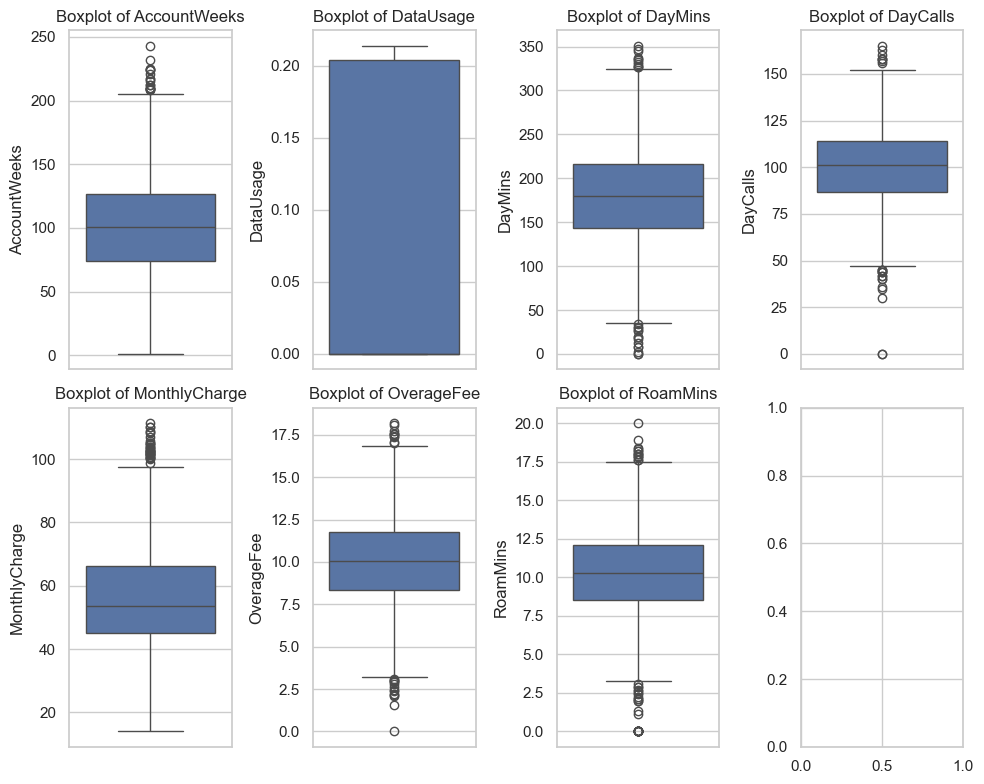

In [88]:
numeric_cols=df[['AccountWeeks','DataUsage','DayMins','DayCalls','MonthlyCharge','OverageFee','RoamMins']]
# Create a combined figure with subplots for all numeric columns' boxplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 8))
axes = axes.flatten()

# Plot each boxplot in a subplot with labels
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_ylabel(col)


plt.tight_layout()
plt.show()

The data seems so uneven because some of the columns have larger values, so to minimize the bias and for our data to predict models properly, we will standardize and PCA on them before using any models. 

Now we will work on models and creating pipeline for PCA, standardization, and different models

In [92]:
X=df.drop(columns='Churn',axis=1)
y=df['Churn']

In [124]:
#Creating all the models 
models={"LogisticRegression":Pipeline([
    ("scaler",StandardScaler()),
    ("pca",PCA(n_components=0.95)),
    ("clf", LogisticRegression(max_iter=1000))]),
        "RandomForest":Pipeline([
    ("scaler",StandardScaler()),
    ("pca",PCA(n_components=0.95)),
    ("clf", RandomForestClassifier(n_estimators=100))]),
        "SVM":Pipeline([
    ("scaler",StandardScaler()),
    ("pca",PCA(n_components=0.95)),
    ("clf",SVC(kernel="rbf",class_weight="balanced",probability=True))]),}

In [144]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=991111) 

results={}

In [145]:
# utitlizing the models to predict their accuracy and using mean of all the running test
for name, pipe in models.items(): 
    scores=cross_val_score(pipe,X,y,cv=cv,scoring="accuracy")
    results[name]={
        "mean_accuracy": scores.mean(),
        "std_accuracy": scores.std()}

for name, stats in results.items():
    print(f"{name:20s} Accurary: {stats['mean_accuracy']:.3f} std+- {stats['std_accuracy']:.3f}")

LogisticRegression   Accurary: 0.861 std+- 0.006
RandomForest         Accurary: 0.915 std+- 0.004
SVM                  Accurary: 0.915 std+- 0.006


# RandomForest and SVM both have similar accuracy. So according to the test we conducted, we can use both the models. Even the Standard Deviation is not significant to actually choose one model

In [ ]:

dump(models["SVM"], "svm_churn_pipeline.joblib")

dump(models["RandomForest"], "RandomForest_churn_pipeline.joblib")

# Dumping the file so we can use it again to predict a separate dataframe